# Dive Prediction - Hidden Markov Model

*Predicting Seabird Diving Behaviour from GPS data*

This notebook trains a HMM to predict seabirds' dives.

HMM' characteristics:

* *Number of modes* : 3

<div class="alert alert-info">
 ⚠️ Notebook using R
</div>

In [10]:
library(momentuHMM)
library(CircStats)

In [11]:
data_test = read.table("./data/data_test.csv", sep = ',', header = TRUE)

In [12]:
# prep data for HMM
rawData <- data_test[,c("trip","lon","lat")]
colnames(rawData) <- c("ID", "lon", "lat")
birdData <- prepData(data=rawData, type = "LL", coordNames = c("lon", "lat"))

In [13]:
# parameters initialization

## cluster K-Means for initialization
### STEP
clusterBird_step <- kmeans(na.omit(data.frame(birdData$step)), 3)
muS_1 <- max(clusterBird_step$centers)
muS_2 <- median(clusterBird_step$centers) 
muS_3 <- min(clusterBird_step$centers) 
sdS_1 <- sd(na.omit(birdData$step)[clusterBird_step[[1]] == which(clusterBird_step$centers == max(clusterBird_step$centers))])
sdS_2 <- sd(na.omit(birdData$step)[clusterBird_step[[1]] == which(clusterBird_step$centers == median(clusterBird_step$centers))])
sdS_3 <- sd(na.omit(birdData$step)[clusterBird_step[[1]] == which(clusterBird_step$centers == min(clusterBird_step$centers))])

### ANGLE
## for von mises
kappaA_1 <- 4
kappaA_2 <- 2
kappaA_3 <- 0.1

### ZERO MASS
zeroMass <- length(which(birdData$step == 0))/nrow(birdData) #we need to include zeroMass parameters

### FIT MODEL
stateNames <- c("fly","observe", "dive")
dist = list(step = "gamma", angle = "vm")
anglePar0 <- c(kappaA_1, kappaA_2, kappaA_3) 
stepPar0 <- c(muS_1, muS_2, muS_3, sdS_1, sdS_2, sdS_3, zeroMass, zeroMass, zeroMass) 

In [14]:
m <- fitHMM(data = birdData, nbStates = 3, dist = dist,
            Par0 = list(step = stepPar0, angle = anglePar0), stateNames = stateNames, formula = ~1)

save(m, file = './hmm/hmm_test.RData')


Fitting HMM with 3 states and 2 data streams

-----------------------------------------------------------------------


 step ~ gamma(mean=~1, sd=~1, zeromass=~1)

 angle ~ vm(concentration=~1)


 Transition probability matrix formula: ~1


 Initial distribution formula: ~1


DONE



In [6]:
# load('./hmm/hmm_test.RData')

In [15]:
for (trip in unique(rawData$ID)){
  path = paste0('./hmm/figures/', trip, '.png')
  png(path)
  plot(m, animals = trip, ask = FALSE)
  dev.off()
}


Decoding state sequence... DONE
Decoding state sequence... DONE
Decoding state sequence... DONE
Decoding state sequence... DONE
Decoding state sequence... DONE
Decoding state sequence... DONE
Decoding state sequence... DONE


In [16]:
predict = viterbi(m)
data_test$hmm = predict

In [20]:
moveHMM::allProbs

ERROR: Error: 'allProbs' is not an exported object from 'namespace:moveHMM'


## get probabilities

In [44]:
load("/home/amdroy/MEGA/SCRIPT/BirdDL/hmm/hmm_test.RData")

# load home-made functions
a = lapply(list.files(path= "/home/amdroy/MEGA/SCRIPT/BirdDL/hmm/momentuHMM/R", pattern = "[.]R$", 
                      full.names = TRUE, recursive = TRUE), source)

In [64]:
probs = allProbs(m)
data_test$prob =  probs[,3]/apply(probs, 1, sum)

## change resolution

In [70]:
dive_real = list()
dive_estim = list()

for (i in unique(data_test$trip)){
    trip = data_test[data_test$trip == i,]
    
    real = sapply(seq(1,nrow(trip)-10, by = 10), function(i){
        max(trip$dive[i:(i+9)])
    })
    
    estim = sapply(seq(1,nrow(trip)-10, by = 10), function(i){
        mean(trip$prob[i:(i+9)])
    })
        
    dive_real[[i]] = real
    dive_estim[[i]] = estim
}

## score

In [76]:
# globally
all_estim <- 1*unlist(dive_estim)>0.2
all_real <- unlist(dive_real)


true_positive = mean(all_estim[all_real == 1])
true_negative = 1-mean(all_estim[all_real == 0])

print(c(true_positive, true_negative))

[1] 0.8327759 0.7760766


# ROC curve

In [79]:
# globally
TP = list()
FP = list()

i = 1
for (tt in seq(0,1, by = 0.05)){
    # globally
    all_estim <- 1*unlist(dive_estim)>tt
    all_real <- unlist(dive_real)

    true_positive = mean(all_estim[all_real == 1])
    true_negative = 1-mean(all_estim[all_real == 0])
    
    TP[[i]] <- true_positive
    FP[[i]] <- 1- true_negative
    i = i+1
}

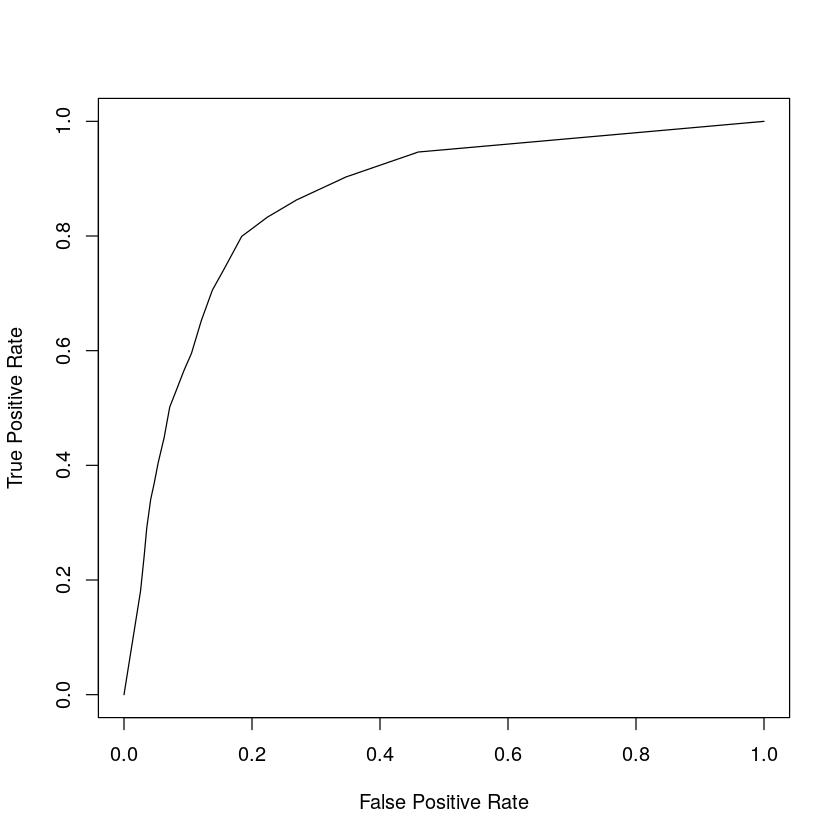

In [83]:
plot(unlist(FP), unlist(TP), pch = 19, xlab = 'False Positive Rate', ylab = 'True Positive Rate', type = 'l')

In [85]:
df = data.frame(model = 'hmm', FP = unlist(FP), TP = unlist(TP))

In [88]:
write.table(df, file = './roc/roc_hmm.csv', sep = ',')